Importing Libraries

In [ ]:
# install kaggle so we can import data
! pip install kaggle
# make a directory for the json file 
! mkdir ~/.kaggle
# create json file
! touch ~/.kaggle/kaggle.json 
# write my kaggle private key to it -- professionally this would be bad practise to have your private key in plain text but for the purpose of the assignment
# it allows us to quickly run this and not have to reupload the file every time we run it as collab deletes the workspace 
! echo '{"username":"seanr00","key":"35346e6b61c63080501214c2295c139c"}' >> ~/.kaggle/kaggle.json
# Change permissions
! chmod 600 ~/.kaggle/kaggle.json
# download the dataset as a zip
! kaggle datasets download yusufemir/lemon-quality-dataset
# unzip the file
! unzip lemon-quality-dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 228M/233M [00:02<00:00, 116MB/s] 
100% 233M/233M [00:02<00:00, 82.3MB/s]
Archive:  lemon-quality-dataset.zip
  inflating: lemon_dataset/.git/COMMIT_EDITMSG  
  inflating: lemon_dataset/.git/FETCH_HEAD  
  inflating: lemon_dataset/.git/HEAD  
  inflating: lemon_dataset/.git/config  
  inflating: lemon_dataset/.git/description  
  inflating: lemon_dataset/.git/hooks/applypatch-msg.sample  
  inflating: lemon_dataset/.git/hooks/commit-msg.sample  
  inflating: lemon_dataset/.git/hooks/fsmonitor-watchman.sample  
  inflating: lemon_dataset/.git/hooks/post-update.sample  
  inflating: lemon_dataset/.git/hooks/pre-applypatch.sample  
  inflating: lemon_dataset/.git/hooks/pre-commit.sample  
  inflating: lemon_dataset/.git/hooks/pre-merge-commit.sample  
  inflating: lemon_dataset/.git/hooks/pre-push.sample  
  inflating: lemon_dataset/.git/hooks/pre-rebase.sample  
  inflating: lemon_datas

In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.model_selection import train_test_split
                                              
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

Split Data

In [ ]:
! pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Split the folders into test train val 

---



In [ ]:
import splitfolders
! rm -r "/content/lemon_dataset/.git"
! rm -r "/content/images2"

input_folder = '/content/lemon_dataset'


os.mkdir("/content/images2/")
output = "/content/images2/"


# split the folders by ratio 70% to the train folder, 20% to the test, 10% to the validation
splitfolders.ratio(input_folder, output, seed = 42, ratio=(.7, .2, .1), group_prefix=None)

rm: cannot remove '/content/images2': No such file or directory


Copying files: 2528 files [00:00, 3041.67 files/s]


Defining Data Paths

In [ ]:
# delete unwanted .git files that sometimes gets transferred over

! rm -r "/content/images2/test/.git"
! rm -r "/content/images2/train/.git"
! rm -r "/content/images2/val/.git"

rm: cannot remove '/content/images2/test/.git': No such file or directory
rm: cannot remove '/content/images2/train/.git': No such file or directory
rm: cannot remove '/content/images2/val/.git': No such file or directory


In [ ]:
# set the paths for train test and validation
train_path = r"/content/images2/train"
test_path = r"/content/images2/test"
val_path = r"/content/images2/val"

empty_background


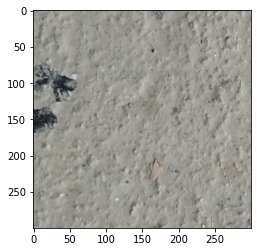

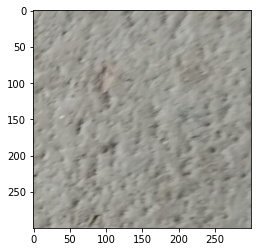

bad_quality


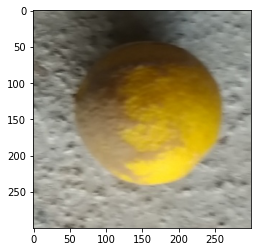

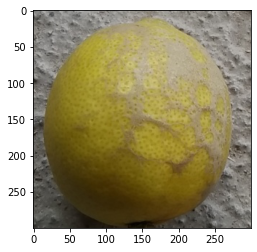

good_quality


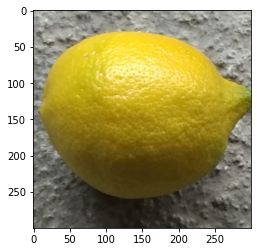

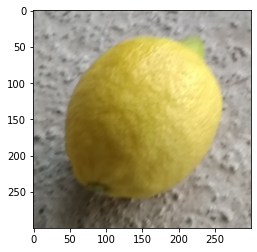

In [ ]:
# loop through the folders print 2 images from each sub directory
# good quality, bad quality and no lemon

for folder in os.listdir(train_path):
    if not folder.startswith('.'):
        sub_path = train_path + "/" + folder

        print(folder)
        for i in range(2):
            temp_path = os.listdir(sub_path)[i]
            temp_path = sub_path + "/" + temp_path
            img = mpimg.imread(temp_path)
            implot = plt.imshow(img)
            plt.show()

Converting images to pixels

In [ ]:
# go into each sub folder, get image and convert to pixels
# resize image so they are all the same size - take this in through a variable size that we have in the next cell
# store these in an empty data array
def imagearray(path, size):
    data = []
    for folder in os.listdir(path):
        sub_path = path + "/" + folder
        
        for img in os.listdir(sub_path):
            image_path = sub_path + "/" + img
            img_arr = cv2.imread(image_path)
            img_arr = cv2.resize(img_arr, size)
            data.append(img_arr)

    return data 

In [ ]:
size = (200, 200)

In [ ]:
# run the imagearray function declared above for each folder
train = imagearray(train_path, size)
test = imagearray(test_path, size)
val = imagearray(val_path, size)

Normalization

In [ ]:
# store the data in a numpy array. this is faster and less memory intensive than a regular python array 
# seperate arary for each data set
x_train = np.array(train)
x_test = np.array(test)
x_val = np.array(val)

In [ ]:
# divide the data by 255
# this will make all the data be stored between 0-1.
# computation will be easier and faster

x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0
  

Defining Target vars

In [ ]:
def data_class(data_path,size,class_mode):
    # scale the images by 255 so they 
    datagen = ImageDataGenerator(rescale = 1./255)

    # takes the data from the np array 
    # target size is the size of the images
    # batch size determines how many images are passed through the network at one time 
    # class mode is set to sparse with bad quality 0, empty background 1, good quailty 2
    classes = datagen.flow_from_directory(data_path,
                                          target_size = size,
                                          batch_size = 16,
                                          class_mode = class_mode)
    return classes

In [ ]:
# pass the arguments to the data_class function declared above
train_class = data_class(train_path, size, "sparse")
test_class = data_class(test_path, size, "sparse") 
val_class = data_class(val_path, size, "sparse")


Found 1768 images belonging to 3 classes.
Found 255 images belonging to 3 classes.
Found 505 images belonging to 3 classes.


In [ ]:

y_train = train_class.classes
y_test = test_class.classes
y_val = val_class.classes

In [ ]:
train_class.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [ ]:
# show the indices from categorical cross entropy
train_class.class_indices

{'bad_quality': 0, 'empty_background': 1, 'good_quality': 2}

In [ ]:
print( "Y_train_shape ", y_train.shape,
"Y_test_shape ",y_test.shape,
"Y_val_shape ",y_val.shape )

Y_train_shape  (1768,) Y_test_shape  (255,) Y_val_shape  (505,)


VGG19 Model

In [ ]:
# we are using a pre trained vgg19 that has been pretrainined on imageNet
# we are nopt including the fully connnected top layer
vgg = VGG19(input_shape = (200, 200, 3), weights = "imagenet", include_top = False)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
# prevents the weights from being updated during training
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
# convert this to a 1D continuous array 
# set up 3 fully connected layers for the output to make predictions on images
x = Flatten()(vgg.output)
prediction = Dense(3, activation = 'softmax')(x)

In [ ]:
# create a summary of all the layers and paramaters

model =Model(inputs = vgg.input, outputs = prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

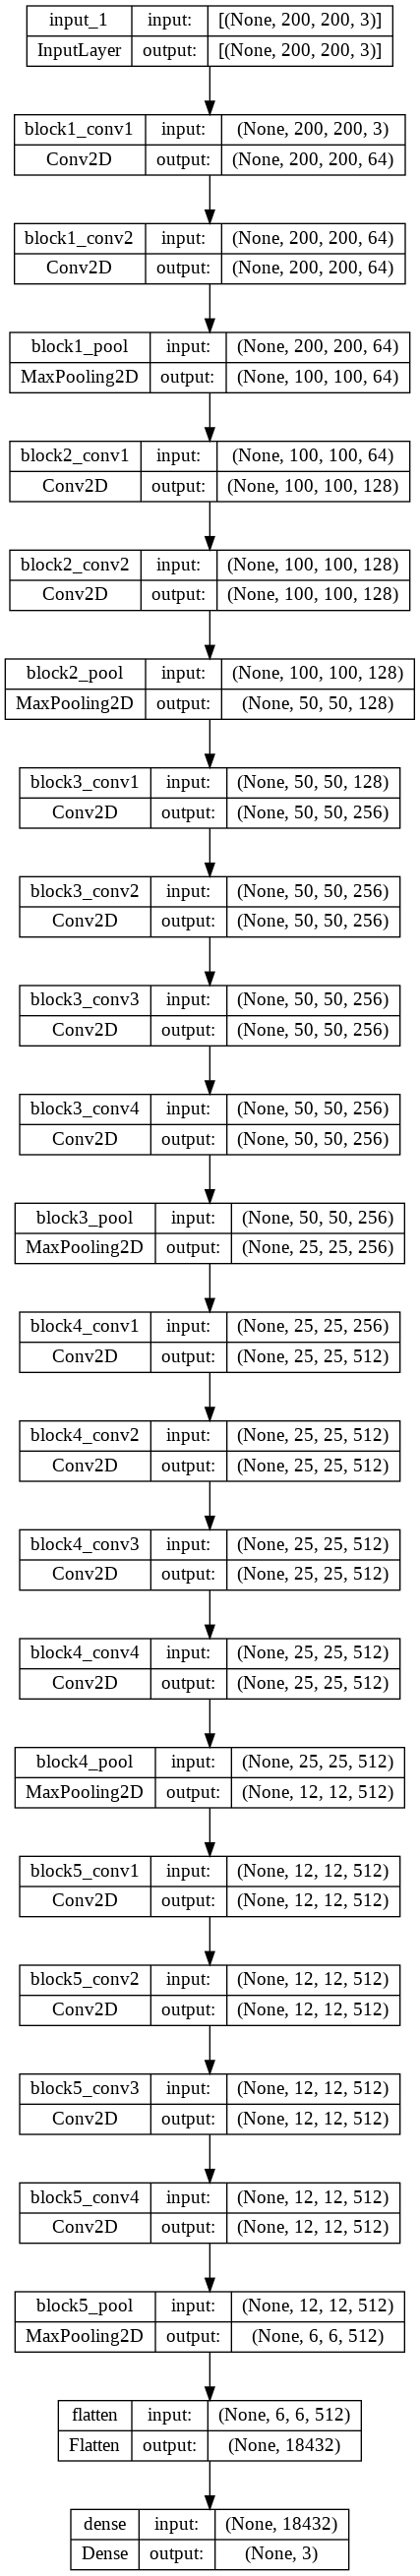

In [ ]:
plot_model(model = model, show_shapes = True)

In [ ]:

# early stopping can help prevent overfitting
# if the learning hasnt changed in 5 epochs cancel
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose  = 1, patience = 5)

In [ ]:
# Configure the model using the sparse categorical crossentrpy as the loss function
# use the adam optimizer (adaptive moment estimation algorithm)
# focusing on the accuracy as the metric to be evaluated during training
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
               metrics = ["accuracy"])

In [ ]:
# we are setting this as a variable so we can use it to generate graphs 
# conmape the x_train and y_train arrays vs the validation arrays
# we do this for 10 times through the data set - 10 epochs
# we set the batch size 

history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 10, callbacks=[early_stop], batch_size = 8,
                    shuffle=True)

Epoch 1/10
221/221 [==============================] - 1216s 5s/step - loss: 0.6954 - accuracy: 0.7562 - val_loss: 0.7257 - val_accuracy: 0.6792
Epoch 2/10
221/221 [==============================] - 1160s 5s/step - loss: 0.4312 - accuracy: 0.8348 - val_loss: 0.8407 - val_accuracy: 0.7782
Epoch 3/10
221/221 [==============================] - 1159s 5s/step - loss: 0.3851 - accuracy: 0.8473 - val_loss: 0.5041 - val_accuracy: 0.7861
Epoch 4/10
221/221 [==============================] - 1158s 5s/step - loss: 0.2774 - accuracy: 0.8824 - val_loss: 0.4630 - val_accuracy: 0.7881
Epoch 5/10
221/221 [==============================] - 1153s 5s/step - loss: 0.2712 - accuracy: 0.8971 - val_loss: 0.4767 - val_accuracy: 0.7960
Epoch 6/10
221/221 [==============================] - 1157s 5s/step - loss: 0.2294 - accuracy: 0.9112 - val_loss: 0.6438 - val_accuracy: 0.7782
Epoch 7/10
221/221 [==============================] - 1165s 5s/step - loss: 0.1450 - accuracy: 0.9383 - val_loss: 0.5869 - val_accuracy:

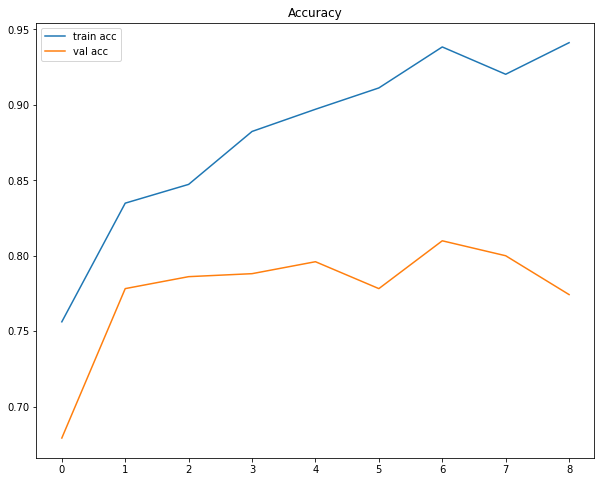

In [ ]:
#  create a plot of this copmairing the training accuracy against the validation set

plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()


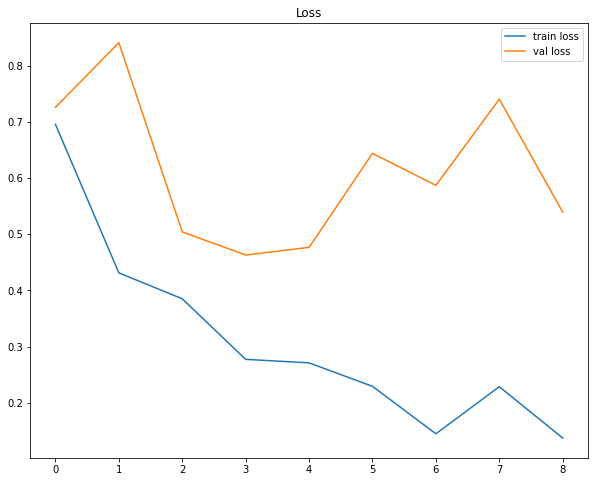

In [ ]:
# create a plot of the loss comparing the training set and validation set 

plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
# calculate the errors and accuracy of the model
model.evaluate(x_test, y_test, batch_size=32)

8/8 [==============================] - 132s 16s/step - loss: 0.5942 - accuracy: 0.7882


[0.5941951870918274, 0.7882353067398071]

In [ ]:
y_pred = model.predict(x_test)

8/8 [==============================] - 129s 16s/step


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       110
           1       0.30      0.42      0.35        33
           2       0.98      0.99      0.99       112

    accuracy                           0.79       255
   macro avg       0.69      0.70      0.69       255
weighted avg       0.81      0.79      0.80       255



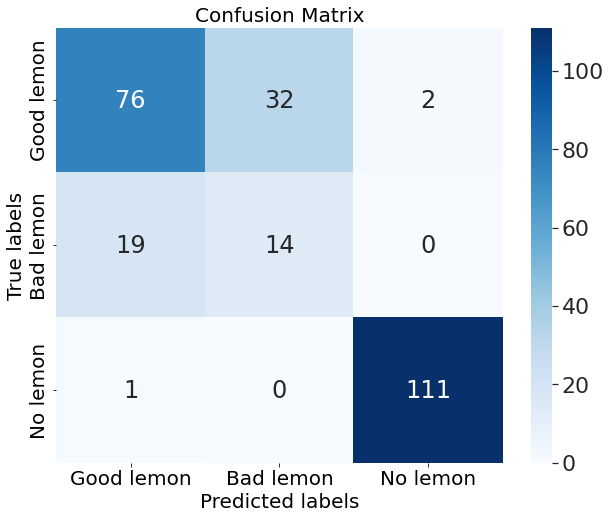

In [ ]:
# create a confusion matrix

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)


ax.set_xlabel('Predicted labels', fontsize=20);
ax.set_ylabel('True labels', fontsize =20);
ax.set_title('Confusion Matrix', fontsize=20);
ax.xaxis.set_ticklabels(['Good lemon', 'Bad lemon', 'No lemon'], fontsize=20); ax.yaxis.set_ticklabels(['Good lemon', 'Bad lemon', 'No lemon'], fontsize=20);


In [ ]:
# print the precision of the model 
f1_score(y_test, y_pred, average='micro')

0.788235294117647

In [ ]:
#  another method to evaluate the precision of the model
# the ratio between correctly predicted positive samples and total positive samples
recall_score(y_test, y_pred, average='weighted')


0.788235294117647

In [ ]:
#  another method to evaluate the precision of the model
# ratio between total number of samples classed as positive (either corrrectly or incorrectly)
precision_score(y_test, y_pred, average='micro')

0.788235294117647

In [ ]:
# save the model
model.save("/content/")